# BEE 4750 Final Project Code

**Name**: 

**ID**: 

> **Due Date**
>


## Setup


=== DNA-only ===
Running HiGHS 1.12.0 (git hash: 755a8e027): Copyright (c) 2025 HiGHS under MIT licence terms
MIP has 27 rows; 15 cols; 52 nonzeros; 1 integer variables (1 binary)
Coefficient ranges:
  Matrix  [1e+00, 4e+01]
  Cost    [3e+05, 1e+06]
  Bound   [1e+00, 1e+00]
  RHS     [1e+00, 4e+01]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-27); columns 0(-15); nonzeros 0(-52) - Reduced to empty
Presolve: Optimal

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic;
     I => Shifting; J => Feasibility jump; L => Sub-MIP; P => Empty MIP; R => Randomized rounding;
     S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution; Y => HiGHS solution;
     Z => ZI Round; l => Trivial lower; p => Trivial point; u => Trivial upper; z => Trivial zero

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueu

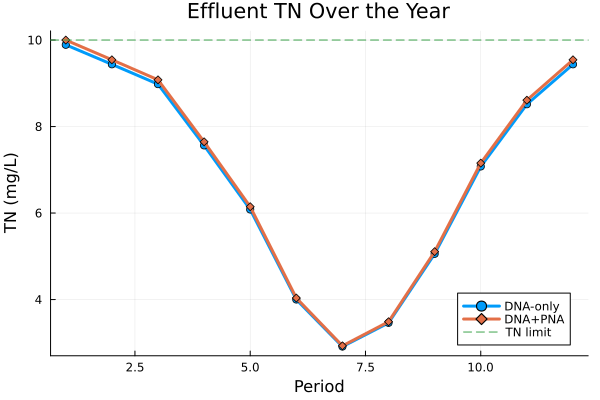

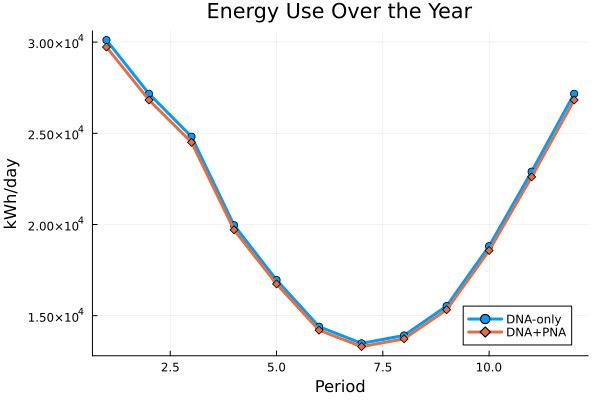

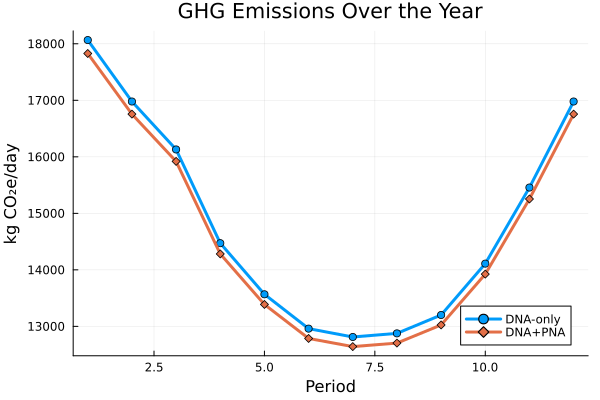

In [21]:
using JuMP
using HiGHS
using Plots

# =========================
# 1. DATA / PARAMETERS
# =========================

# Time periods (e.g., months)
T   = 1:12
nT  = length(T)

# Flow and load (assumed constant over the year for now)
Q   = 100_000.0                   # m3/d 
Cin = 40.0                        # mg N/L
Lin = Q * Cin / 1000.0            # kg N/d

# Days in each period (approx monthly)
days = fill(365.0 / 12.0, nT)

# Temperature profile (°C) for each month (example data)
T_deg = [8.0, 9.0, 10.0, 13.0, 16.0, 20.0,
         22.0, 21.0, 18.0, 14.0, 11.0, 9.0]

# === Temperature-dependent removal efficiencies (Arrhenius / θ form) ===

T_ref       = 20.0        # reference temperature (°C)
eta_DNA_ref = 0.90        # DNA removal at T_ref
eta_PNA_ref = 0.85        # PNA removal at T_ref

theta_DNA   = 1.015       # weak temperature dependence (DNA)
theta_PNA   = 1.03        # stronger temperature dependence (Anammox)

eta_DNA = [eta_DNA_ref * theta_DNA^(T_deg[t] - T_ref) for t in T]
eta_PNA = [eta_PNA_ref * theta_PNA^(T_deg[t] - T_ref) for t in T]

# keep efficiencies valid
eta_DNA = clamp.(eta_DNA, 0.0, 0.999)
eta_PNA = clamp.(eta_PNA, 0.0, 0.999)

# === Temperature-dependent energy use ===

# Aeration energy (kWh per kg N removed) at T_ref
e_DNA_ref = 4.0
e_PNA_ref = 1.0

# More energy when it's colder (simple scaling)
e_DNA = [e_DNA_ref * (T_ref / T_deg[t]) for t in T]
e_PNA = [e_PNA_ref * (T_ref / T_deg[t]) for t in T]

# Heating energy for PNA (bring to 20 °C)
T_set_PNA = 20.0
k_heat    = 0.05
e_heat = [max(T_set_PNA - T_deg[t], 0.0) * k_heat for t in T]

# Effluent TN limit
TN_target = 10.0                  # mg/L

# Economic & GHG parameters
c_elec       = 0.10               # $/kWh
EF_elec      = 0.4                # kg CO2e/kWh (grid)
EF_DNA       = fill(2.0, nT)      # kg CO2e/kgN removed in DNA
EF_PNA       = fill(0.5, nT)      # kg CO2e/kgN removed in PNA
SCC          = 80.0               # $/ton CO2e

# Annualized capex for PNA
AnnualCapex_PNA = 500_000.0       # $/year

# =========================
# 2. FUNCTION (OPTIMIZATION FORMAT)
# =========================

"""
    solve_case(allow_PNA::Bool)

Chemical/energy/CO2 optimization model for DNA vs PNA.
"""
function solve_case(allow_PNA::Bool)
    model = Model(HiGHS.Optimizer)

    # Decision variables
    @variables(model, begin
        0 <= x_DNA <= 1          # fraction of N load to DNA
        0 <= x_PNA <= 1          # fraction of N load to PNA
        y_PNA, Bin               # binary: build PNA or not
        Ceff[t in T]             # effluent TN mg/L
    end)

    # Flow split
    @constraint(model, x_DNA + x_PNA == 1)

    # === OPTION 1: FORCE PNA BUILT IN SCENARIO 2 ===
    if allow_PNA
        @constraint(model, pna_must_build, y_PNA == 1)
        @constraint(model, pna_only_if_built, x_PNA <= y_PNA)

        # OPTIONAL: force some PNA flow to create visible separation
        # @constraint(model, min_pna_flow, x_PNA >= 0.20)

    else
        @constraint(model, x_PNA == 0)
        @constraint(model, y_PNA == 0)
    end

    # Nitrogen loads
    @expression(model, L_DNA, x_DNA * Lin)
    @expression(model, L_PNA, x_PNA * Lin)

    # N removed per month
    @expression(model, R_DNA[t in T], eta_DNA[t] * L_DNA)
    @expression(model, R_PNA[t in T], eta_PNA[t] * L_PNA)

    # Effluent TN mass balance
    @constraint(model, effluent_mb[t in T],
        Ceff[t] == (Lin - R_DNA[t] - R_PNA[t]) / Q * 1000.0
    )

    # TN limit
    @constraint(model, eff_limit[t in T], Ceff[t] <= TN_target)

    # Energy per month
    @expression(model, E_DNA[t in T], e_DNA[t] * R_DNA[t])
    @expression(model, E_PNA[t in T], e_PNA[t] * R_PNA[t])
    @expression(model, E_heat[t in T], e_heat[t] * L_PNA)

    @expression(model, E_total[t in T], E_DNA[t] + E_PNA[t] + E_heat[t])

    # Energy cost
    @expression(model, Cost_energy,
        sum(days[t] * c_elec * E_total[t] for t in T)
    )

    # Emissions
    @expression(model, CO2_total[t in T],
        E_total[t] * EF_elec +
        R_DNA[t] * EF_DNA[t] +
        R_PNA[t] * EF_PNA[t]
    )

    @expression(model, Cost_GHG,
        sum(days[t] * CO2_total[t] * (SCC/1000.0) for t in T)
    )

    # Objective
    @objective(model, Min,
        y_PNA * AnnualCapex_PNA + Cost_energy + Cost_GHG
    )

    optimize!(model)
    status = termination_status(model)

    # Extract results
    return (
        status      = status,
        x_DNA       = value(x_DNA),
        x_PNA       = value(x_PNA),
        y_PNA       = value(y_PNA),
        Ceff        = [value(Ceff[t]) for t in T],
        E_total     = [value(E_total[t]) for t in T],
        CO2_total   = [value(CO2_total[t]) for t in T],
        energy_cost = value(Cost_energy),
        ghg_cost    = value(Cost_GHG),
        capex_cost  = value(y_PNA) * AnnualCapex_PNA,
        total_cost  = value(Cost_energy) + value(Cost_GHG) + value(y_PNA) * AnnualCapex_PNA
    )
end

# =========================
# 3. RUN SCENARIOS
# =========================

println("=== DNA-only ===")
res_DNA = solve_case(false)

println("=== DNA+PNA (forced build) ===")
res_PNA = solve_case(true)

println()
println("DNA-only total cost:   ", res_DNA.total_cost)
println("DNA+PNA total cost:    ", res_PNA.total_cost)
println("x_DNA, x_PNA (DNA)     ", res_DNA.x_DNA, ", ", res_DNA.x_PNA)
println("x_DNA, x_PNA (PNA)     ", res_PNA.x_DNA, ", ", res_PNA.x_PNA)

# =========================
# 4. PLOTS
# =========================

period_labels = collect(T)

## 1 — Cost comparison bar plot
capex_vals  = [res_DNA.capex_cost,  res_PNA.capex_cost]
energy_vals = [res_DNA.energy_cost, res_PNA.energy_cost]
ghg_vals    = [res_DNA.ghg_cost,    res_PNA.ghg_cost]
cost_matrix = hcat(capex_vals, energy_vals, ghg_vals)

p1 = bar(
    ["DNA-only", "DNA+PNA"],
    cost_matrix,
    label = ["Capex", "Energy", "GHG"],
    ylabel = "Annual Cost (\$)",
    title = "Annual Cost Breakdown",
    legend = :topright,
    bar_position = :stack
)

## 2 — Effluent TN over the year
p2 = plot(period_labels, res_DNA.Ceff,
    label="DNA-only", xlabel="Period", ylabel="TN (mg/L)",
    title="Effluent TN Over the Year", lw=3, marker=:circle)
plot!(p2, period_labels, res_PNA.Ceff,
    label="DNA+PNA", lw=3, marker=:diamond)
hline!(p2, [TN_target], label="TN limit", linestyle=:dash)
display(p2)

## 3 — Energy use over the year
p3 = plot(period_labels, res_DNA.E_total, label="DNA-only",
    xlabel="Period", ylabel="kWh/day",
    title="Energy Use Over the Year", lw=3, marker=:circle)
plot!(p3, period_labels, res_PNA.E_total,
    label="DNA+PNA", lw=3, marker=:diamond)
display(p3)

## 4 — GHG emissions
p4 = plot(period_labels, res_DNA.CO2_total, label="DNA-only",
    xlabel="Period", ylabel="kg CO₂e/day",
    title="GHG Emissions Over the Year", lw=3, marker=:circle)
plot!(p4, period_labels, res_PNA.CO2_total,
    label="DNA+PNA", lw=3, marker=:diamond)
display(p4)
